# **Policy Network Training**

Below is the code for training the Policy network agent mentioned in the paper. In the paper we trained this network against the random battle agent and greedy battle agent but we observed no improvement in performance after training against the greedy battle agent. 

We used the Proximal Policy Optimization algorithm to train the network.

**Personal note:** this code is heavily inspired by the code from "Deep-Reinforcement-Learning-Hands-On-Second-Edition" by Maxim Lapan. This book helped me learn a lot about actually implementing reinforcement learning algorithms and I highly recommend it. Much of the code from this book can be found here https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition .

*It is important to open drive and install gym-locm so that the AI can play games*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/locm_project
! git clone https://github.com/ronaldosvieira/gym-locm.git
%cd gym-locm
! pip install -e .

/content/drive/My Drive/locm_project
fatal: destination path 'gym-locm' already exists and is not an empty directory.
/content/drive/My Drive/locm_project/gym-locm
Obtaining file:///content/drive/My%20Drive/locm_project/gym-locm
  Running setup.py develop for gym-locm


*Imports*

In [ ]:
import numpy as np
import collections
import random
import math
import time
from operator import attrgetter
from typing import Type

from gym_locm.engine import *

import gym
import gym.spaces

import pexpect
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.optim as optim

import matplotlib.pyplot as plt

**Random Battle Agent** - plays cards and picks actions randomly. We require this agent to act as an adversary while training the network.

In [ ]:
class RandomBattleAgent():
  def __init__(self, seed=None):
    self.random = random.Random(seed)

  def seed(self, seed):
    self.random.seed(seed)

  def reset(self):
    pass

  def act(self, state):
    index = int(len(state.available_actions) * random.random())

    return state.available_actions[index]

In [ ]:
**Greedy Battle Agent** - plays cards that maximize the value of a handcrafted heuristic (see paper for more details). We can use this agent as a more advanced adversary once this network has learned to beat the random battle agent frequently enough.

In [ ]:
class GreedyBattleAgent():
    def seed(self, seed):
        pass

    def reset(self):
        pass

    @staticmethod
    def eval_state(state):
        
        def eval_creature(creature):
            score = 0

            if creature.attack > 0:
                score += 28.6875
                score += creature.attack * 23.375
                score += creature.defense * 29.625

                if creature.has_ability('W'):
                    score += creature.attack * 26

                if creature.has_ability('L'):
                    score += 29.0625

            if creature.has_ability('G'):
                score += 25.125

            return score
        
        score = 0

        pl = state.current_player
        op = state.opposing_player

        if pl.health < 5:
            score -= 100

        # check opponent's death
        if op.health <= 0:
            score += 100000

        # check own death
        elif pl.health <= 0:
            score -= 100000

        # health difference
        score += (pl.health - op.health) * 2
        
        for c in pl.hand:
            if not isinstance(c, Creature):
                score += 14.6875

        if len(pl.hand) + pl.bonus_draw + 1 <= 8:
            score += (pl.bonus_draw + 1) * 20.625
                
        for pl_lane, op_lane in zip(pl.lanes, op.lanes):
            # creature strength
            score += sum(eval_creature(c) for c in pl_lane)
            score -= sum(eval_creature(c) for c in op_lane)

        return score

    def act(self, state):
        best_action, best_score = None, float("-inf")

        if len(state.available_actions) == 1:
            return state.available_actions[0]
        
        for action in state.available_actions:
            state_copy = state.clone()
            state_copy.act(action)

            score = self.eval_state(state_copy)
            if score > best_score:
                best_action, best_score = action, score
        return best_action

# **Main training code**

In [ ]:
def available_actions():
  available_actions = env.state.available_actions
  action_numbers = []

  for action_number in range(env.action_space.n):
    action = env.decode_action(action_number)
    if action in available_actions:
      action_numbers.append(action_number)

  return np.array(action_numbers, dtype=np.int64)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class PPO(nn.Module):
  def __init__(self, input_shape, n_actions):
    super(PPO, self).__init__()

    self.actor = nn.Sequential(
      nn.Linear(np.array(input_shape).prod(), 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, n_actions)
    )
    self.critic = nn.Sequential(
      nn.Linear(np.array(input_shape).prod(), 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1)
    )

    self.apply(init_weights)

  def forward(self, x, mask):
    x = x.view(x.size(0),-1)
    fx = x.float() / 256

    policy = self.actor(fx)
    value = self.critic(fx)

    masked_policy = policy.masked_fill(~mask, -np.inf)
    return masked_policy, value

def calc_adv_ref(values, dones, rewards, gamma, gae_lambda):
  last_gae = 0.0
  adv, ref = [], []

  for val, next_val, done, reward in zip(reversed(values[:-1]), reversed(values[1:]),
                                           reversed(dones[:-1]), reversed(rewards[:-1])):
    if done:
      delta = reward - val
      last_gae = delta
    else:
      delta = reward + gamma * next_val - val
      last_gae = delta + gamma * gae_lambda * last_gae
    adv.append(last_gae)
    ref.append(last_gae + val)
  adv = list(reversed(adv))
  ref = list(reversed(ref))
  return torch.FloatTensor(adv), torch.FloatTensor(ref)
  
def train(batch):
    optimizer.zero_grad()

    states_t, actions_t, masks_t, advantage, ref, old_logprob = batch
    policy, values = net(states_t, masks_t)
    loss_value = F.mse_loss(values.squeeze(-1), ref)

    logpolicy = F.log_softmax(policy, dim=1)
    logpolicy = logpolicy.masked_fill(~masks_t, 0.0)

    probs = F.softmax(policy, dim=1)
    loss_entropy = (probs * logpolicy).sum(dim=1).mean()

    logprob = logpolicy.gather(1, actions_t.unsqueeze(-1)).squeeze(-1)
    ratio = torch.exp(logprob - old_logprob)
    surr_obj = advantage * ratio
    clipped_surr = advantage * torch.clamp(ratio, 1.0 - CLIP_GRAD, 1.0 + CLIP_GRAD)
    loss_policy = -torch.min(surr_obj, clipped_surr).mean()

    loss = ENTROPY_BETA * loss_entropy + loss_policy + loss_value
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
      
GAMMA = 0.99
LEARNING_RATE = 1e-5
ENTROPY_BETA = 0.01
BATCH_SIZE = 64

PPO_TRAJ = 1025
PPO_EPOCHS = 2
CLIP_GRAD = 0.2

GAE_LAMBDA = 0.95

seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name = "LOCM-battle-v0"
# Change this to the GreedyBattleAgent() once the network is beating the random agent frequently (typically 12-20 hours of training)
env = gym.make(name, battle_agent=RandomBattleAgent())

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)
env.action_space.seed(seed)

net = PPO(env.observation_space.shape, env.action_space.n).to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

print(net)

best_m_reward = 0.0
n_episode = 0
ep_rewards = collections.deque(maxlen=100)
losses = []
m_rewards = []
m_losses = []
frame_idx = 0

try:
  params = torch.load('../../../../drive/My Drive/training/locm-ppo-save.chkpt')
  net.load_state_dict(params['net'])
  optimizer.load_state_dict(params['optimizer'])
  frame_idx = params['frame_idx']
  n_episode = params['n_episode']
  best_m_reward = params['best_m_reward']
  print("Resuming training session from locm-ppo-save.chkpt")
except:
  print("Starting fresh training session")

ts_frame = frame_idx
ts = time.time()

while True:
    
  states = []
  actions = []
  masks = []
  rewards = []
  dones = []
  last_done_index = None

  state = env.reset()
  
  for _ in range(PPO_TRAJ):
    with torch.no_grad():

      indices = torch.tensor(available_actions())
      mask = torch.zeros(env.action_space.n, dtype=torch.bool)
      mask.scatter_(0, indices, True)

      mask = mask.unsqueeze(0).to(device)

      state = torch.from_numpy(state).float().unsqueeze(0).to(device)

      logits, _ = net(state, mask)
      
      probs = F.softmax(logits, dim=1)
      dist = Categorical(probs)
      
      action = dist.sample()
      next_state, reward, done, _ = env.step(action.cpu().numpy())

      states.append(state)
      actions.append(action)
      masks.append(mask)
      rewards.append(reward)
      dones.append(done)

      state = next_state

      if done:
        last_done_index = len(states) - 1
        state = env.reset()

    frame_idx += 1

    if reward:
      n_episode += 1
      
      if reward == 1:
        ep_rewards.append(1)
      else:
        ep_rewards.append(0)

      if len(ep_rewards) == 100:
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()

        m_reward = np.mean(ep_rewards)
        m_loss = np.mean(losses[-100:])
          
        m_rewards.append(m_reward)
        m_losses.append(m_loss)

        if best_m_reward < m_reward:
          print("NEW BEST MEAN REWARD --> {:.2f}% win rate".format(m_reward*100))
          best_m_reward = m_reward

        print("frame: {},  episode: {}, win rate: {:.1f}%, loss: {:.4f}, f/s: {:.2f}".format(
              frame_idx, n_episode, m_reward*100, m_loss, speed
        ))

        torch.save({'net':net.state_dict(), 'optimizer':optimizer.state_dict(), 'frame_idx':frame_idx, 
                    'n_episode':n_episode, 'best_m_reward':best_m_reward}, '../../../../drive/My Drive/training/locm-ppo-save.chkpt')

        ep_rewards = collections.deque(maxlen=100)
        losses.clear()

    if len(states) < PPO_TRAJ:
      continue

    if last_done_index is None or last_done_index == len(states)-1:
      continue

    states = states[:last_done_index+2]
    actions = actions[:last_done_index + 2]
    masks = masks[:last_done_index + 2]
    rewards = rewards[:last_done_index + 2]
    dones = dones[:last_done_index + 2]
       
    states_t = torch.cat(states).to(device)
    actions_t = torch.tensor(actions).to(device)
    masks_t = torch.cat(masks).to(device)
    
    policy, values = net(states_t, masks_t)
    values = values.squeeze()

    advantage, ref = calc_adv_ref(values.data.cpu().numpy(),
                                      dones, rewards, GAMMA, GAE_LAMBDA)
    advantage = advantage.to(device)
    ref = ref.to(device)

    logpolicy = F.log_softmax(policy, dim=1)
    old_logprob = logpolicy.gather(1, actions_t.unsqueeze(-1)).squeeze(-1)
    advantage = (advantage - torch.mean(advantage)) / torch.std(advantage)
    old_logprob = old_logprob.detach()

    len_trajectory = len(states) - 1
    len_trajectory -= len_trajectory % BATCH_SIZE
    len_trajectory += 1
    indices = np.arange(0, len_trajectory-1)

    for _ in range(PPO_EPOCHS):
      np.random.shuffle(indices)
      for batch_indices in np.split(indices, len_trajectory // BATCH_SIZE):
            train((
                          states_t[batch_indices],
                          actions_t[batch_indices],
                          masks_t[batch_indices],
                          advantage[batch_indices],
                          ref[batch_indices],
                          old_logprob[batch_indices],
                      ))
            
    states.clear()
    actions.clear()
    masks.clear()
    rewards.clear()
    dones.clear()

*Let's display the win rate and loss during training*

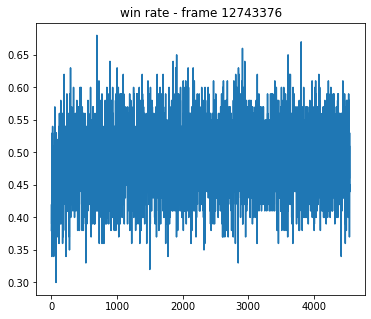

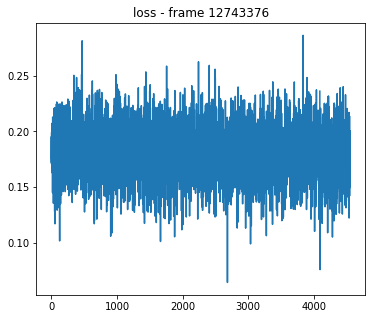

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('win rate - frame {}'.format(frame_idx))
plt.plot(m_rewards)
plt.show()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('loss - frame {}'.format(frame_idx))
plt.plot(m_losses)
plt.show()